Контакты:
    **почта:** a.polushkin@tbank.ru
    **tg** @username_1233

# Курс "Управление рисками"
# Семинар 4: Линейная регрессия на примере предсказания дохода

## Часть 1. Предобработка данных

In [252]:
import pandas as pd
import numpy as np
# import holoviews as hv
# hv.extension('matplotlib')

import matplotlib.pyplot as plt

In [253]:
df = pd.read_csv('./income_dataset.csv',sep=';')
df.head()

,id,in_total_amt,income,job_salary,gender,age,car_own_flg,avg_limit,max_limit,credit_num,acc_num,out_total_amt
0,0,8110.825000,30000.0,32000,1,22.0,0,12847.00000,23862.0,7,9.0,38657.606406
1,1,25600.000000,50000.0,32000,0,26.0,0,26381.50000,24611.0,3,7.0,51272.839585
2,2,216091.400000,30000.0,38000,0,25.0,0,9176.48857,33998.0,14,3.0,147950.296174
3,3,106000.661389,50000.0,40000,0,36.0,0,32152.50000,23451.0,4,6.0,99925.392161
4,4,102672.375000,50000.0,17000,0,23.0,0,38493.50000,585000.0,9,7.0,78125.045718


In [254]:
len(df)

55200

In [255]:
df

,id,in_total_amt,income,job_salary,gender,age,car_own_flg,avg_limit,max_limit,credit_num,acc_num,out_total_amt
0,0,8110.825000,30000.0,32000,1,22.0,0,12847.00000,23862.0,7,9.0,38657.606406
1,1,25600.000000,50000.0,32000,0,26.0,0,26381.50000,24611.0,3,7.0,51272.839585
2,2,216091.400000,30000.0,38000,0,25.0,0,9176.48857,33998.0,14,3.0,147950.296174
3,3,106000.661389,50000.0,40000,0,36.0,0,32152.50000,23451.0,4,6.0,99925.392161
4,4,102672.375000,50000.0,17000,0,23.0,0,38493.50000,585000.0,9,7.0,78125.045718
...,...,...,...,...,...,...,...,...,...,...,...,...
55195,55195,29282.480000,650000.0,73000,0,27.0,0,17874.00000,0.0,2,5.0,84105.622110
55196,55196,9650.000000,48234.0,29000,1,41.0,0,168401.50000,0.0,2,7.0,68372.873056
55197,55197,185333.333333,200000.0,144000,0,37.0,0,729903.19714,800000.0,16,7.0,359484.607452
55198,55198,12200.000000,50000.0,37000,1,37.0,0,97232.33333,246015.0,7,6.0,61308.665102


#### Описание признаков

- id - уникальный id клиента
- in_total_amt - среднемесячные пополнения карты 
- gender - пол (1 - женский, 0 - мужской)
- age - возраст
- car_own_flg - наличие авто
- avg_limit - средняя сумма кредита
- max_limit - максимальная сумма кредита
- job_salary - средняя зарплата по должности
- credit_num - количество кредитов
- acc_num - количество счетов
- out_total_amt - среднемесячные траты

**Целевая переменная:** income

#### Предварительный отбор

Для начала внимательно изучим признаки. В данных есть уникальное для каждого объекта поле id. 
Нужно удалить это поле, так как оно способствуют переобучению.

**Вопрос:** Почему поля типа id могут вызвать переобучение модели? потому что они уникальны и для них модель не ищет закономерности, а может запомнить конкретные примеры

Не все признаки являются числовыми, пока что мы не будем рассматривать такие признаки.

In [256]:
numeric = [ 'in_total_amt', 'avg_limit', 'job_salary','gender'] # остальные признаки попадают в домашнее задание

#### Разделение выборки на обучающую и тестовую

Нам нужно обучить модель линейной регрессии и провалидировать ее (убедиться, что модель продолжает работать). Для этого используют обучающую и тестовую выборки (кроме этого выделяют и валидационную выборку - для настройки гиперпараметров, например в случае Ридж- и Лассо-регресии). 

Обычно обучающую и тестовую выборки получают разделением выборки на две подвыборки в каком-то соотношении (например 80% - трейн, 20% - тест). Сделать это можно:
- случайно (метод *train_test_split* в sklearn.model_selection)
- по времени (упорядочить выборку по id и разделить в соотношении)

**Вопрос:** В каких случаях нам может быть важно поделить выборку случайно, а в каких - по времени? 
данные имеют временную структуру;
мы моделируем реальный прогноз в будущее;
распределение данных может меняться со временем.

In [257]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df[numeric], df['income'], test_size=0.3, shuffle=False) # shuffle=False - делим по времени

#### Построим модель

Попробуем обучить модель линейной регрессии на "сырых" данных и посчитать метрику $R^2$.

In [258]:
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression

def fit_predict(X_train, y_train, X_test, y_test, predictor_list):
    model = LinearRegression()
    model.fit(X_train[predictor_list],y_train)
    prediction = model.predict(X_test[predictor_list])
    message = (
    f"R2_train: {round(r2_score(y_train, model.predict(X_train[predictor_list])),4)}\n"
    f"R2_test: {round(r2_score(y_test,prediction), 4)}")

    print(message)
    return prediction

In [259]:
fit_predict(X_train, y_train, X_test, y_test, numeric);

R2_train: 0.1587
R2_test: 0.1107


Видим, что метрика $R^2$ на обучающей выборке $0.1587$, а разница между метриками на обучающей и тестовой выборках $0.048$.

#### Целевая переменная (Таргет)

Построим гистограмму распределения целевой переменной:

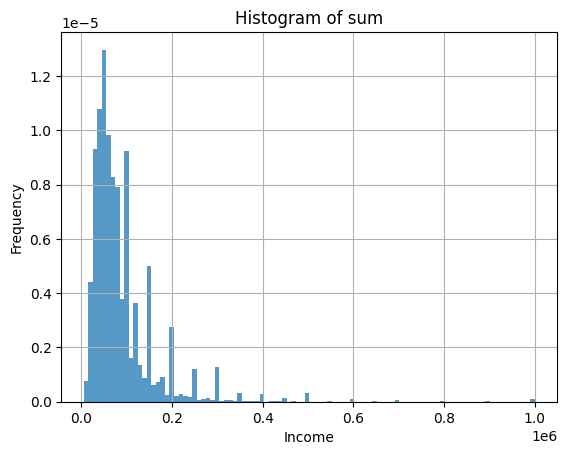

In [260]:
n, bins, patches = plt.hist(y_train, 100, density=True, alpha=0.75)
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.title('Histogram of sum')
plt.grid(True)
plt.show()

На гистограмме видим длинный хвост распределения. 

**Вопрос:** Почему нужно убрать выделяющиеся наблюдения? MSE сильно штрафует за выбросы, из-за этого оценки коэффициентов оказываются смещёнными в сторону экстремальных наблюдений, и модель начинает подстраиваться под них, ухудшая качество аппроксимации для большинства данных.
Подсказка: Какую функцию минимизируем при вычислении оценок коэффициентов? Что произойдет, если вычислим ее на большом значении целевой переменной? Как это повлияет на модель?

Исключим из обучающей выборки наблюдения, попадающие за 95-квантиль распределения:

In [261]:
X_train = X_train[y_train <= np.percentile(y_train, 95)]
y_train = y_train[y_train <= np.percentile(y_train, 95)]


Вычислим логарифм дохода:

In [262]:
y_train = np.log(y_train.clip(lower=1)) 
y_test =  np.log(y_test.clip(lower=1)) 

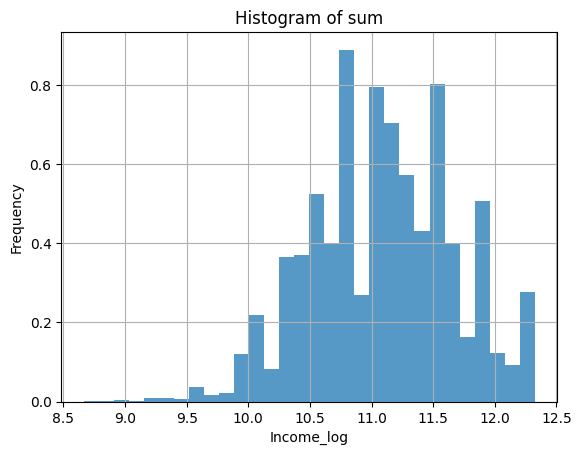

In [263]:
n, bins, patches = plt.hist(y_train, 30, density=True, alpha=0.75)
plt.xlabel('Income_log')
plt.ylabel('Frequency')
plt.title('Histogram of sum')
plt.grid(True)
plt.show()

---

Немного про обучение модели линейной регрессии.

Для обучения модели линейной регрессии будем использовать sklearn: в нем понятный и простой интерфейс. Также можно использовать statsmodels (в нем более обширный функционал и реализованы статистические тесты).

В sklearn есть несколько классов, реализующих линейную регрессию:

- LinearRegression — "классическая" линейная регрессия с оптимизацией MSE. Веса находятся как точное решение: $$a=(𝑋^𝑇𝑋)^{−1}𝑋^𝑇𝑦$$
- Ridge — линейная регрессия с оптимизацией MSE и ℓ2-регуляризацией
- Lasso — линейная регрессия с оптимизацией MSE и ℓ1-регуляризацией


У моделей из sklearn есть методы fit и predict. Первый принимает на вход обучающую выборку и вектор целевых переменных и обучает модель, второй (вызываем после метода fit) возвращает предсказание на выборке. 

## Часть 2. Подготовка данных для применения модели

На лекции мы обсудили предположения, в которых уместно применять модель линейной регрессии: $X^TX$ - невырожденная матрица, 
𝑦 линейно зависит от $x$, остатки $\varepsilon_i$ независимы и $\varepsilon_i \sim N(0,\sigma)$.

На практике эти предположения гарантируются при выполнении условий:
 
1. **Линейность зависимости предикторов и таргета**

2. **Гомоскедастичность**
	$$De = \sigma^{2}I$$
    
3. **Нормальность ошибок**
	$$e \sim N_{n}(0,\sigma^{2}I)$$

4. **Отсутствие мультиколлинеарности**
	$$rank(X) = m + 1 $$

### Линейность зависимости

При постановке задачи мы сделали предположение о линейной зависимости целевой переменной $y$ от предикторов $x_i$. 

Проверить линейность можно графически. Для этого нужно визуализировать\* зависимость между предиктором и целевой переменной (например, с помощью диаграммы рассеивания).


\* При слишком большом количестве точек они обычно группируются по бакетам.

В качестве метрики оценки линейности признака можно использовать $R^2$ простой линейной регрессии на выбранном признаке относительно целевой переменной. 

#### Scatterplot

Построим диаграмму рассеивания для некоторых признаков:

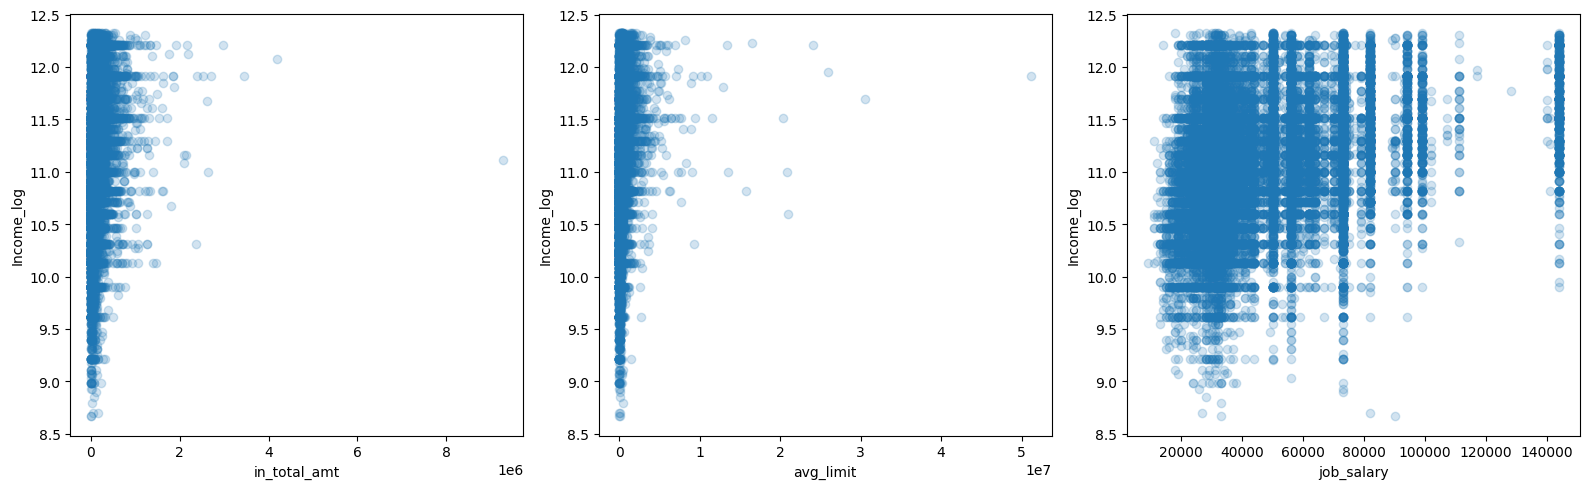

In [264]:
fig, axs = plt.subplots(figsize=(16, 5), ncols=3)
for i, feature in enumerate(['in_total_amt','avg_limit','job_salary']):
    axs[i].scatter(X_train[feature], y_train, alpha=0.2)
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel("Income_log")
plt.tight_layout()
plt.show()

### Feature_line

В случае, когда наблюдений очень много (как в нашей выборке), можно разбить признак по бакетам и построить среднее и квантили целевой переменной для каждого бакета. Такую визуализацию будем называть feature_line. 

Алгоритм построения feature_line:

1. Сгруппируем наблюдения по бакетам признака (бакеты одного размера, для непрерывных признаков можем использовать количество бакетов nbins > 10) 

2. Вычислим среднее значение целевой переменной для каждого бакета признака (соединим их пунктирной линией) 

3. Для каждого бакета добавим квантили $0.25$ и $0.75$ (обозначим вертикальными линиями)



![feature_line_.png](feature_line_.png)

И выведем гистограмму распределения признака:

![feature_line_hist_.png](feature_line_hist_.png)

Feature_line позволяет оценить характер зависимости целевого признака от предиктора. 
На примере feature_line признака in_total_amt видно, что зависимость не линейная, у распределения длинный хвост (крайний бакет расположен около точки 380000), значения целевой переменной как будто "загибаются" при больших значениях признака.

$R^2=0.055$

[Задание 1](#task1)

### Преобразования

Когда признак нелинейный, может помочь:
- непрерывное монотонное преобразование, линеаризующее признак (это может быть логарифмирование, возведение в квадрат и т.д. В частных случаях бывают и другие типы функций,например, парабола)
- разбиение переменной на линейные фрагменты

**Вопрос:** Почему важна монотонность преобразования? сохраняет порядок наблюдений и направление влияния признака на таргет, позволяя линеаризовать зависимость без искажения смысла признака и без введения искусственной нелинейной структуры в модель, которая может создать исскуственные экстремумы.

Лианеризуем признак in_total_amt. Для преобразования этого признака выберем функцию логарифма.

![feature_line_log.png](feature_line_log.png)

Гистограмма распределения признака выглядит так

![feature_line_log_hist.png](feature_line_log_hist.png)

Видно, что признак "распрямился". Значение метрики $R^2$ так же увеличилось.

### Ограничения значений признака

На графике feature_line для непреобразованного значения видно, что наблюдения из хвоста распределения сгруппированы в крайний бакет с серединой ~380000. Можем ограничить экспертно значением 400000.

На графике feature_line логарифмированного признака видно, что слева значение целевой переменной находится на "плато". Линейной зависимости в этом случае не будет. Ограничим признак снизу, например значением 3000. 

**Вопрос:** Можем ли ограничить признак "сильнее"? 

![feature_line_log_limit.png](feature_line_log_limit.png)

![feature_line_log_limit_hist.png](feature_line_log_limit_hist.png)

Видим, что метрика $R^2$ увеличилась на $0.02$.

Сохраним значения преобразованного признака:

In [265]:
X_train['in_total_amt_log'] = np.log(X_train['in_total_amt'].clip(lower=3000, upper=400000))
X_test['in_total_amt_log'] = np.log(X_test['in_total_amt'].clip(lower=3000, upper=400000))

[Задание 2](#task2)

### Проверим гомоскедастичность

Необходимо проверить, что признаки гомоскедастичны, то есть дисперсия ошибки константна на всем предсказании и формально
$$De = \sigma^{2}I$$
Нарушение данного условия приводит к неэффективности оценок регрессии и несоответствию оценок МНК и ОМП

**Способы проверки**: 
- построить график зависимости остатка от предсказания (по необходимости с разбиением на бакеты)
- зависимость разброса от предсказания будет свидетельствовать о гетероскедастичности  
- статистические тесты (к сожалению, универсального нет - каждый позволяет найти гетероскедастичность только определенного вида)

**Способы решения проблемы**
- Преобразование целевой переменной, приводящее к равномерности разброса
- В случае диагональности матрицы ковариаций возможно применение обощенного [МНК]

  $$\hat{a} = (X^{T}\Omega^{-1}X)^{-1}X^{T}\Omega^{-1}y, \;где\; \Omega^{-1} - матрица\; ковариаций\; остатков$$

Мы уже преобразовали целевую переменную (логарифмированием). Поэтому проверим, что было до преобразования переменной и признака in_total_amt, и сравним с тем, что стало после.

#####  Графический тест
Гетероскедастичность будет наблюдаться, если при изменении предсказания будет меняться величина разброса 

In [266]:
def get_residuals(Y,Pred):
    '''Подсчет невязки Y - истинное значение таргета, Pred - предсказанное'''
    return Y - Pred

In [267]:
def check_homoscedacity(predictor,target,f_name):
    simple_model = LinearRegression()
    simple_model.fit(predictor.reshape(-1,1),target)
    predicts = simple_model.predict(predictor.reshape(-1,1))
    return (plt.scatter(predicts,get_residuals(target,predicts)))

Визуализируем зависимость для предсказания линейной регрессии от непреобразованного признака in_total_amt и целевой переменной:

In [268]:
def make_bucket(df,feature, n =  100):
    '''функция, бьющая на бакеты(по умолчанию 100 точек)'''
    return df.assign(bucket = np.ceil(df[feature].rank(pct = True) * n))

In [269]:
def plot_homoscedacity(predictor, target, predictor_name='feature'):
    df_tmp = pd.DataFrame({'predictor':predictor, 'target':target})
    return df_tmp.pipe(make_bucket,'predictor',200)\
                 .groupby(by = ['bucket']).mean()\
                 .pipe(lambda x:check_homoscedacity(np.array(x.predictor),np.array(x.target),predictor_name)) 

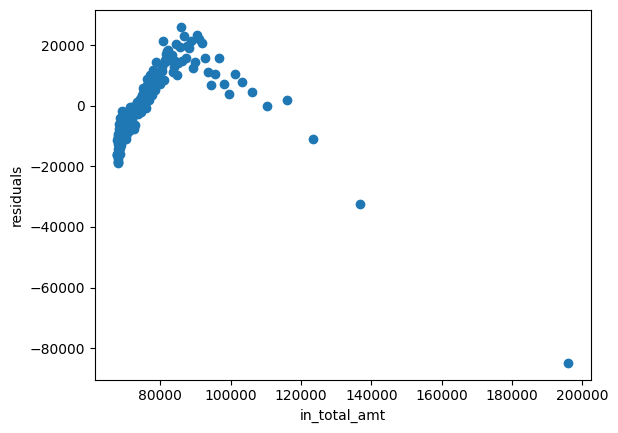

In [270]:
plot_homoscedacity(X_train.in_total_amt, np.exp(y_train),'in_total_amt')
plt.xlabel('in_total_amt')
plt.ylabel('residuals')
plt.show()

Видно, что для признака in_total_amt гомоскедастичность не выполнена (остатки зависят от значения предсказания)

Визуализируем зависимость для предсказания линейной регрессии для преобразованного признака in_total_amt_log и преобразованной целевой переменной:

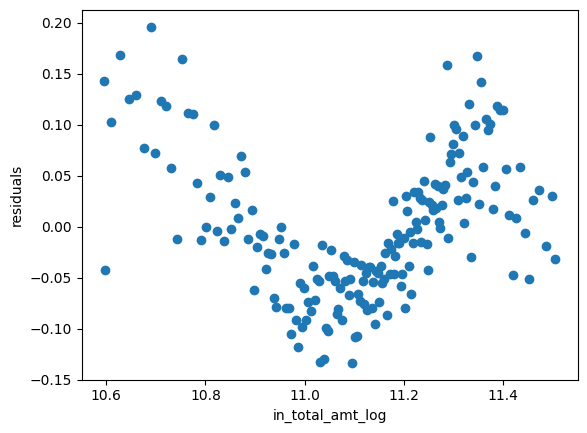

In [271]:
plot_homoscedacity(X_train.in_total_amt_log, y_train,'in_total_amt_log')
plt.xlabel('in_total_amt_log')
plt.ylabel('residuals')
plt.show()

[Задание 3](#task3)

### Нормальность остатков

Необходима для эквивалентности оценок МНК и ОМП

**Способы проверки**
- Статистические критерии
- Построение гистограммы распределения ошибок простой линейной регрессии по признакам или всей модели
- Построение графика QQ-plot (https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot)

**Способы решения проблемы**
- преобразование признака, приводящее к нормальному распределению
- исключение признака из регрессии

In [272]:
numeric_final = ['in_total_amt_log','avg_limit', 'gender', 'job_salary']

/Users/nikita/Desktop/вуз/ML/.venv/lib/python3.14/site-packages/sklearn/utils/validation.py:2684: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


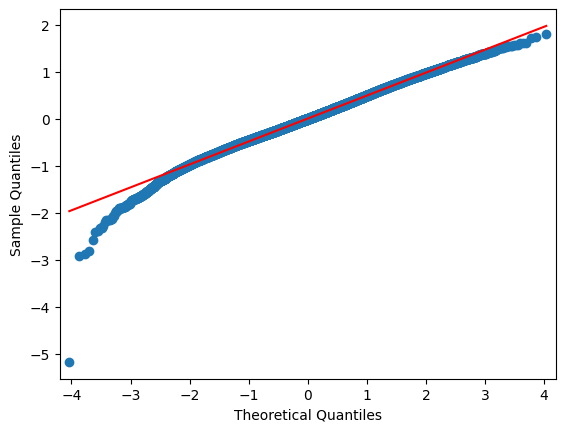

In [273]:
import statsmodels.api as sm
import pylab as py

model = LinearRegression()
model.fit(np.array(X_train[numeric_final]),y_train)
resids = get_residuals(y_train,(model.predict(X_train[numeric_final])))
  
# np.random generates different random numbers
# whenever the code is executed
# Note: When you execute the same code 
# the graph look different than shown below.
  
# Random data points generated
data_points = np.random.normal(0, 1, 100000)    
  
sm.qqplot(np.array(resids), line='s')
py.show()


На этом графике qq-plot видно, что точки не лежат на прямой. Посмотрим на гистограмму распределения остатков.

/Users/nikita/Desktop/вуз/ML/.venv/lib/python3.14/site-packages/sklearn/utils/validation.py:2684: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


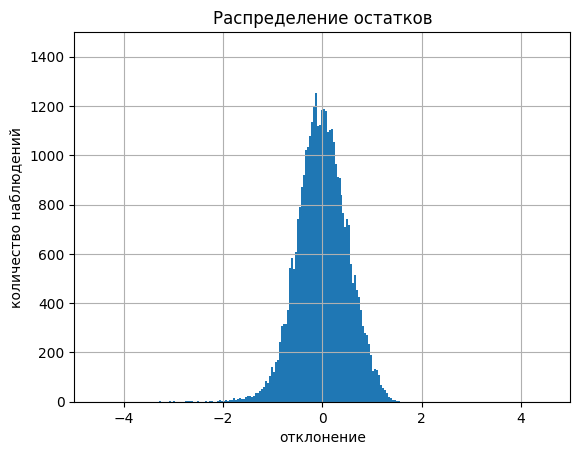

In [274]:
model = LinearRegression()
model.fit(np.array(X_train[numeric]),y_train)
resids = get_residuals(y_train,(model.predict(X_train[numeric])))
plt.hist(resids, bins='auto')[2]
plt.xlabel('отклонение')
plt.ylabel('количество наблюдений')
plt.title('Распределение остатков')
plt.axis([-5, 5, 0, 1500])
plt.grid(True)
plt.show()

Если внимательно посмотреть на распределение, можно увидеть небольшую ассиметричность: "хвосты" распределения немного отличаются.
    
На qq-plot это легко увидеть - в левой части графика точки находятся ниже прямой, т.е. квантили выборочного распределения смещены относительно теоритическиx.

### Мультиколлинеарность

Мультиколлинеарность - проблема близости матрицы X к какой-либо матрице неполного ранга (то есть сильной зависимости признаков между собой).В этом случае матрица $X^TX$ будет плохо обусловленной и решения будут неустойчивыми.

Проверить отсутствие мультиколлинеарности можно:
1. Построив корреляционную матрицу. Если значение коэффициента корреляции >0.3 следует более подробно изучить коррелирующие признаки и преобразовать их или исключить менее эффективный
    
2. Вычислив VIF (Variance Inflation Factor)

#### Проверка коэффициентов корреляции между парами признаков

Проверим, есть ли коррелирующие переменные с выборочным коэффициентов корреляции $>0.3$. Для этого построим матрицу корреляций:

/var/folders/9m/694f26q91vv91hqgk616c7w80000gn/T/ipykernel_62846/165153338.py:1: DeprecationWarning: Please import `pearsonr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.stats.stats import pearsonr


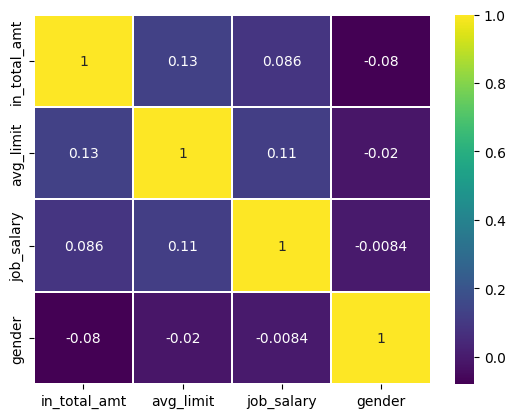

In [275]:
from scipy.stats.stats import pearsonr   
import seaborn as sns

pcorr = pd.DataFrame 
pcorr = []
for f1 in numeric:
    for f2 in numeric:
        pcorr.append((f1,f2,pearsonr(X_train[f1],X_train[f2])))
        
cor = X_train.loc[:,numeric].corr(method='pearson')
cm=plt.cm.viridis
sns.heatmap(cor,cmap=cm,linewidths=0.1,linecolor='white',annot=True)
plt.show()

Видим, что коэффициенты корреляции небольшие (меньше 0.3). 

#### Variance Inflation Factor

Variance Inflation Factor (VIF) позволяет обнаружить корреляцию признака со всеми остальными в совокупности. 

Для вычисления VIF строится k моделей линейной регрессии (здесь k - это количество признаков).

 - i-ый признак выбирается как целевая переменная, оставшиеся признаки - как предикторы. Строится модель линейной регрессии.
 - для предсказанных значений вычисляем VIF:
$$VIF_{i} = \frac{1}{1 - R^{2}_{i}}$$

**Вопросы**: 
   - При каких значениях VIF есть подозрение на линейную зависимость? 5+-

Вычислим значение Variance Inflation Factor для признаков:

In [276]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

pd.DataFrame(data = {'feature':[i for i in numeric],
                     'VIF':[round(variance_inflation_factor(X_train[numeric].values,i),2) for i in range(len(numeric))]}).set_index('feature')

,VIF
feature,
in_total_amt,1.40
avg_limit,1.18
job_salary,1.87
gender,1.38


[Задание 4](#task3)

## Baseline

Построим Baseline

In [277]:
numeric_final = ['in_total_amt_log','avg_limit', 'gender', 'job_salary']

In [278]:
fit_predict(X_train, y_train, X_test, y_test, numeric_final);

R2_train: 0.2627
R2_test: 0.2741


[Задание 5](#task5)

## Качество модели

Немного про интерпретацию $R^2$.

### Интерпретация $R^2$:

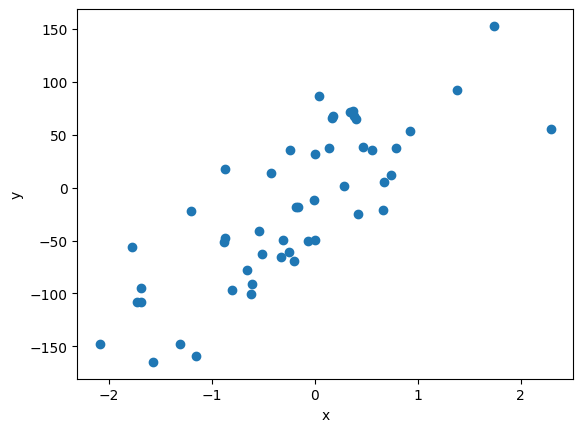

In [279]:
from sklearn.datasets import make_regression
X, y = make_regression(n_samples=50, n_features=1, n_informative=1, noise=50, random_state=89)

plt.scatter(X, y)
plt.xlabel("x")
plt.ylabel("y");

На лекции мы говорили, что метрика $R^2$ означает долю объясненной с помощью линейной модели дисперсии $y$. Разберемся с этим определением подробнее.

Дисперсия – это средний квардрат разброса наблюдений вокруг выборочного среднего:

In [280]:
message = (
    f"Variance by definition: {np.mean( (y - np.mean(y)) ** 2 )}\n"
    f"Variance using function: {np.var(y, ddof=0)}"  # ddof=0 означает, что в знаменателе будет n-0, а не n-1
)

print(message)

Variance by definition: 5283.500549191376
Variance using function: 5283.500549191376


Визуализируем разброс: 

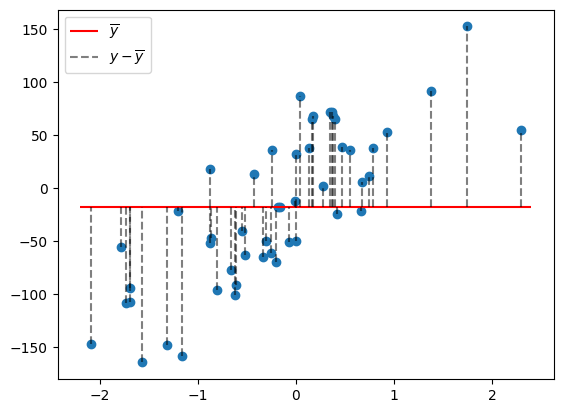

In [281]:
plt.scatter(X, y)

# средний y
plt.hlines(y=np.mean(y), xmin=-2.2, xmax=2.4, color="r", label=r"$\overline{y}$")

# минимум и максимум из двух массивов поэлементно
ymin = np.minimum(y, np.mean(y))
ymax = np.maximum(y, np.mean(y))

# рисуем отклонения от среднего
plt.vlines(x=X, ymin=ymin, ymax=ymax, color="k", linestyles="dashed", alpha=0.5, label=r"$y - \overline{y}$")

plt.legend();
plt.show()

Итак, дисперсия – это сумма квадратов отклонений от среднего (пунктирная линия). Теперь попробуем теперь расчитать **разброс вокруг линии регрессии**:

In [282]:
coef = np.linalg.inv( X.T @ X ) @ X.T @ y  # коэффициенты линейной регрессии
reg_line = X @ coef                        # линия регрессии

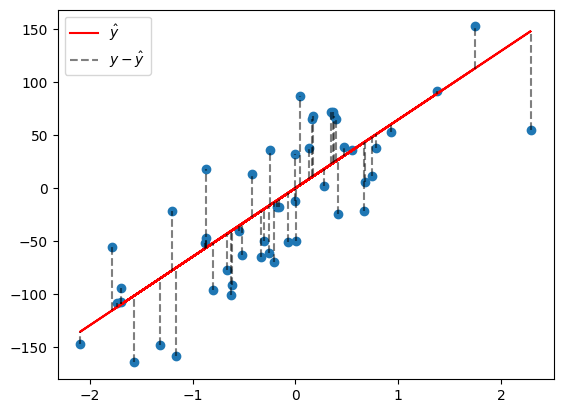

In [283]:
plt.scatter(X, y)
plt.plot(X, reg_line, color="r", label=r"$\hat{y}$")

# минимум и максимум из двух массивов поэлементно
ymin = np.minimum(y, reg_line)
ymax = np.maximum(y, reg_line)

# рисуем отклонения от среднего
plt.vlines(x=X, ymin=ymin, ymax=ymax, color="k", linestyles="dashed", alpha=0.5, label=r"$y - \hat{y}$")

plt.legend()
plt.show()

Итак, мы построили такой же график с разбросом вокруг регрессионной прямой, как и вокруг среднего. Можно заметить, что ошибка в среднем стала меньше – **длины пунктирных линий уменьшились**. Метрика $R^2$ и отвечает на вопрос, насколько в среднем уменьшилась ошибка при переходе от предсказания выборочным средним к регрессии:

$$
R^2 = 1 - \frac{\sum (y_i - \hat y) ^ 2}{\sum (y_i - \overline y) ^ 2}
$$

 - если $R^2 = 0$, это означает, что $\sum (y - \hat y) ^ 2 = \sum (y - \overline y) ^ 2$ – линейная регрессия предсказывает так же, как и выборочное среднее.
 - если $R^2 = 1$, это означает, что $\sum (y - \hat y) ^ 2 = 0$ – все наблюдения расположены на регрессионной прямой.ь

**Вопрос**: Может ли $R^2$ быть отрицательным?

 [Задание 6](#task6)

## Домашнее задание 2: Линейная регрессия
### (10 баллов)

<a id='task1'></a>
##### Задание 1 (3 балла)

1. Реализовать функцию feature_line(var, target, nbins)

    В качестве аргументов функция должна принимать:
     - var: вектор значений признака
     - target: вектор значений целевой переменной
     - nbins: количество бакетов

    и возвращать:
     - график линейности признака
     - количество удаленных наблюдений
     - значение метрики R2
     - гистограмму распределения признака
 
 
2. Проверить линейность признаков с помощью функции feature_line()

In [284]:
from sklearn.metrics import r2_score
import matplotlib as mpl
def feature_line(var, target, nbins, feature_name=None):
    df = pd.DataFrame({
        'var': var,
        'target': target
    })
    df = df.dropna()
    removed_obs = len(var) - len(df)

    df['bucket'] = pd.qcut(df['var'], q=nbins, duplicates='drop')

    grouped = df.groupby('bucket')
    
    stats = grouped['target'].agg(
        mean = 'mean',
        q25 = lambda x: x.quantile(0.25), 
        q75 = lambda x: x.quantile(0.75)
    )

    x = grouped['var'].mean()

    model = LinearRegression()
    model.fit(df['var'].values.reshape(-1, 1), df['target'])
    r2 = model.score(df[['var']], df['target'])

    plt.figure(figsize=(10, 5))

    plt.plot(x, stats['mean'], 'o--', label='Target mean')
    plt.vlines(x, stats['q25'], stats['q75'], alpha=0.7)

    
    x_vals = x.values
    pad = 0.1 * (x_vals.max() - x_vals.min())

    x_line = np.linspace(
        x_vals.min() - pad,
        x_vals.max() + pad,
        x_vals.shape[0]
    ).reshape(-1, 1)
    
    y_line = model.predict(x_line.reshape(-1, 1))

    title_name = feature_name if feature_name is not None else 'Feature'

    plt.plot(x_line, y_line, label='Linear Regression')
    
    plt.xlabel(title_name)
    plt.ylabel('Target')
    plt.title(f'{title_name} | R² = {r2:.3f}')
    
    plt.legend()
    plt.show()

    plt.figure(figsize=(14, 5))
    bin_edges = np.histogram_bin_edges(df['var'], bins='fd')

    # 2. Цветовая карта
    
    cmap = mpl.colormaps.get_cmap('tab10').resampled(len(grouped))

    # 3. Гистограммы по bucket
    for i, (bucket, g) in enumerate(grouped):
        plt.hist(
            g['var'],
            bins=bin_edges,
            density=True,      # <- ключевой момент
            alpha=1,
            color=cmap(i),
            label=str(bucket)
        )
    plt.legend(title='Buckets', loc='upper right')
        
    plt.title(f'Distribution of {title_name}')
    plt.show()

    return {
        'removed_obs': removed_obs,
        'r2': r2
    }

/Users/nikita/Desktop/вуз/ML/.venv/lib/python3.14/site-packages/sklearn/utils/validation.py:2684: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


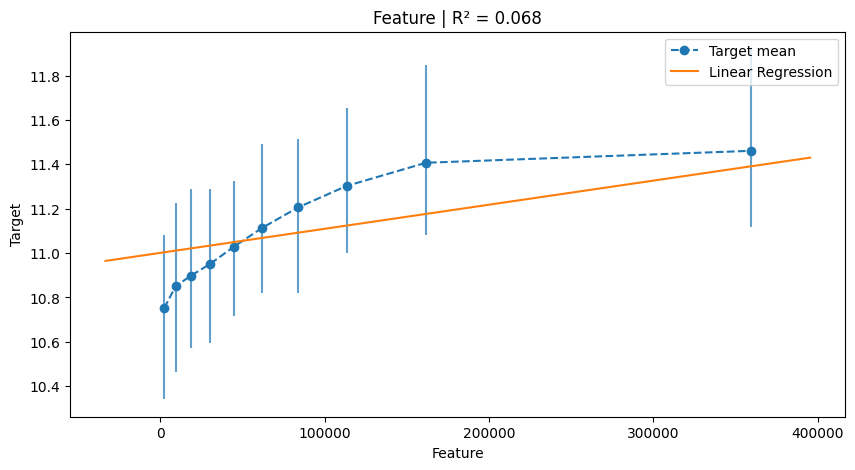

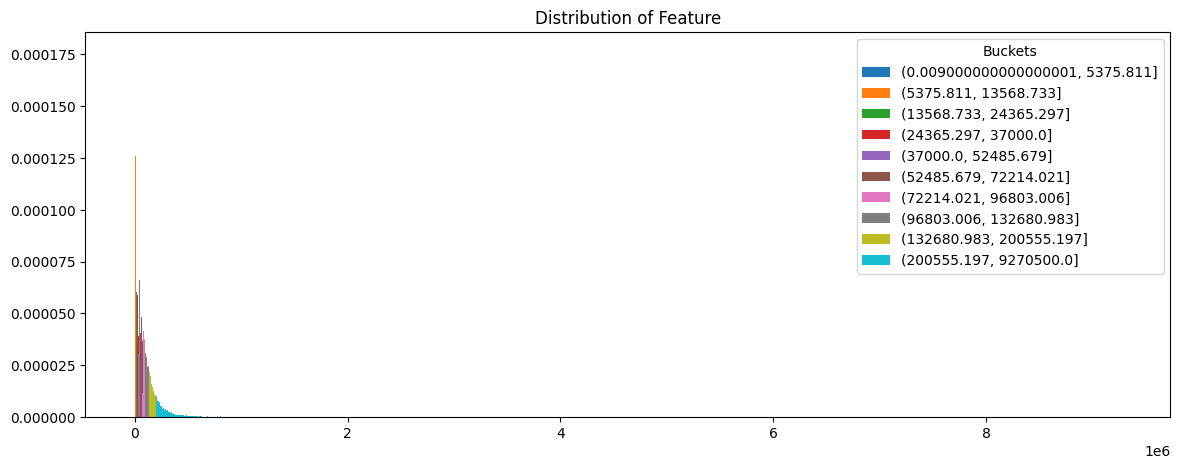

{'removed_obs': 0, 'r2': 0.06824868480575541}

In [285]:
feature_line(X_train['in_total_amt'], y_train, 10)

In [286]:
df

,id,in_total_amt,income,job_salary,gender,age,car_own_flg,avg_limit,max_limit,credit_num,acc_num,out_total_amt
0,0,8110.825000,30000.0,32000,1,22.0,0,12847.00000,23862.0,7,9.0,38657.606406
1,1,25600.000000,50000.0,32000,0,26.0,0,26381.50000,24611.0,3,7.0,51272.839585
2,2,216091.400000,30000.0,38000,0,25.0,0,9176.48857,33998.0,14,3.0,147950.296174
3,3,106000.661389,50000.0,40000,0,36.0,0,32152.50000,23451.0,4,6.0,99925.392161
4,4,102672.375000,50000.0,17000,0,23.0,0,38493.50000,585000.0,9,7.0,78125.045718
...,...,...,...,...,...,...,...,...,...,...,...,...
55195,55195,29282.480000,650000.0,73000,0,27.0,0,17874.00000,0.0,2,5.0,84105.622110
55196,55196,9650.000000,48234.0,29000,1,41.0,0,168401.50000,0.0,2,7.0,68372.873056
55197,55197,185333.333333,200000.0,144000,0,37.0,0,729903.19714,800000.0,16,7.0,359484.607452
55198,55198,12200.000000,50000.0,37000,1,37.0,0,97232.33333,246015.0,7,6.0,61308.665102


In [287]:
numeric = ["in_total_amt", "job_salary", "age", "avg_limit", "max_limit", "credit_num", "acc_num", "out_total_amt"]

X_train, X_test, y_train, y_test = train_test_split(df[numeric], np.log(df['income']), test_size=0.3, shuffle=False) 


/Users/nikita/Desktop/вуз/ML/.venv/lib/python3.14/site-packages/sklearn/utils/validation.py:2684: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


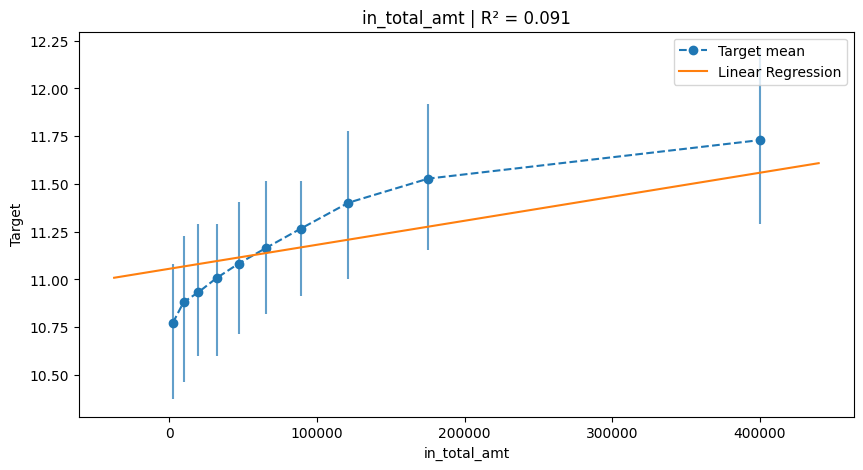

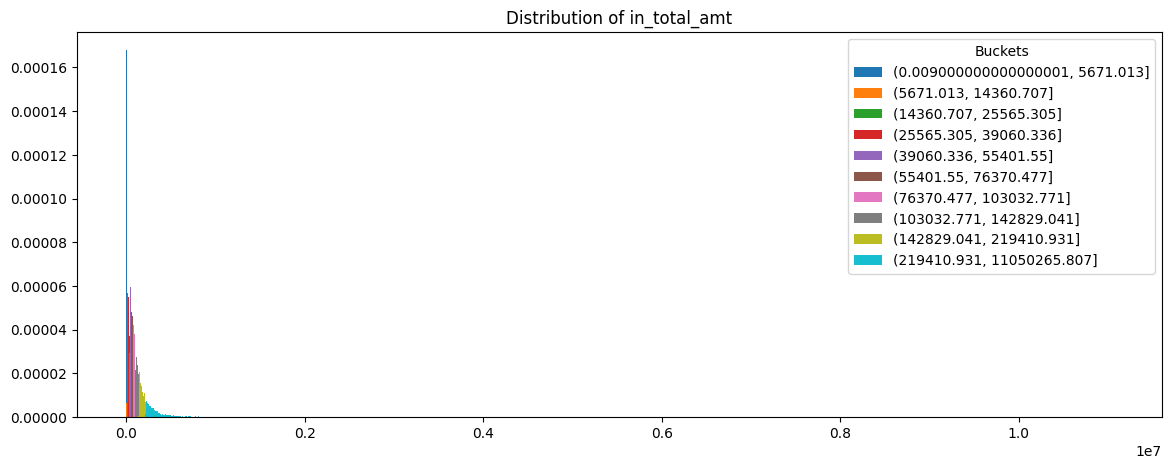

/Users/nikita/Desktop/вуз/ML/.venv/lib/python3.14/site-packages/sklearn/utils/validation.py:2684: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


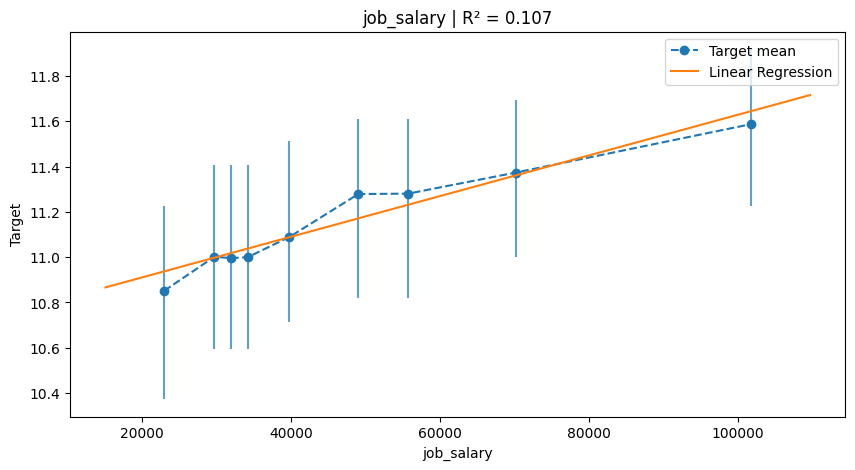

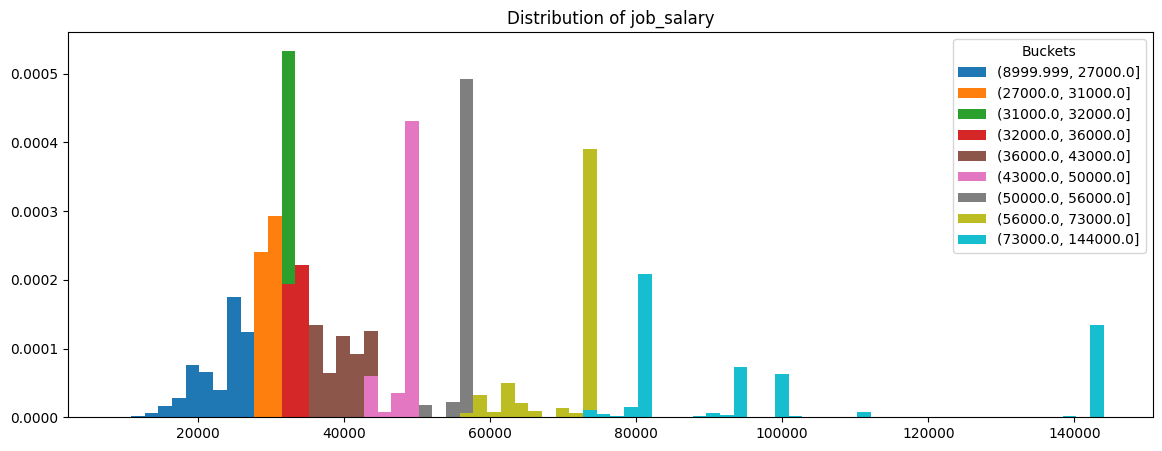

/Users/nikita/Desktop/вуз/ML/.venv/lib/python3.14/site-packages/sklearn/utils/validation.py:2684: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


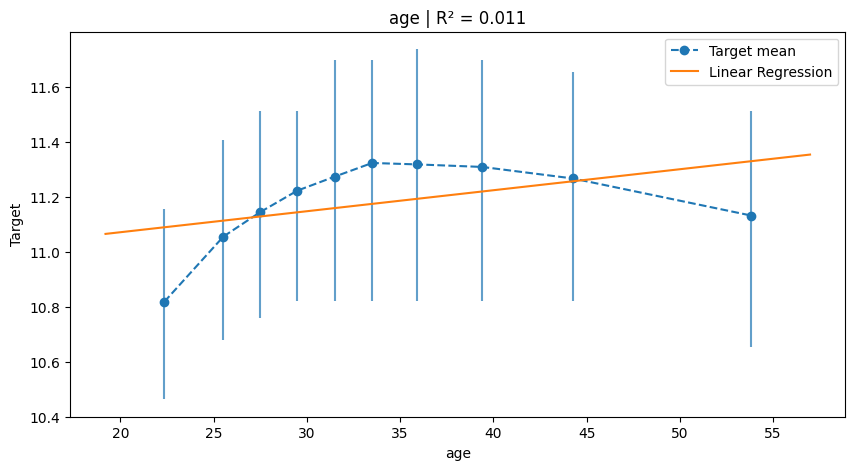

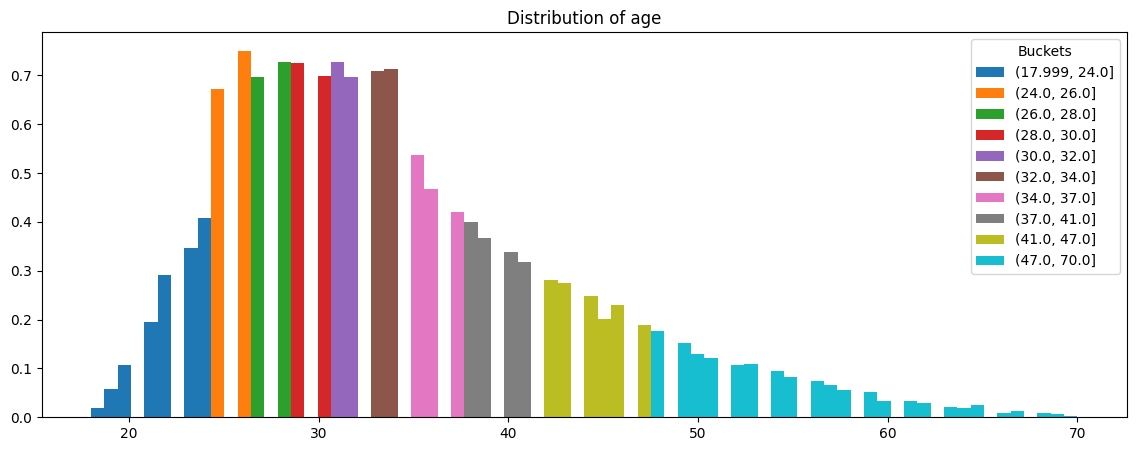

/Users/nikita/Desktop/вуз/ML/.venv/lib/python3.14/site-packages/sklearn/utils/validation.py:2684: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


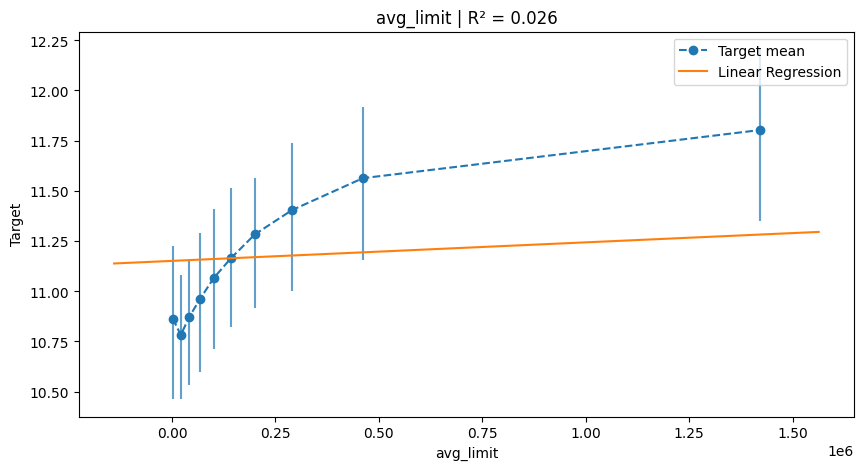

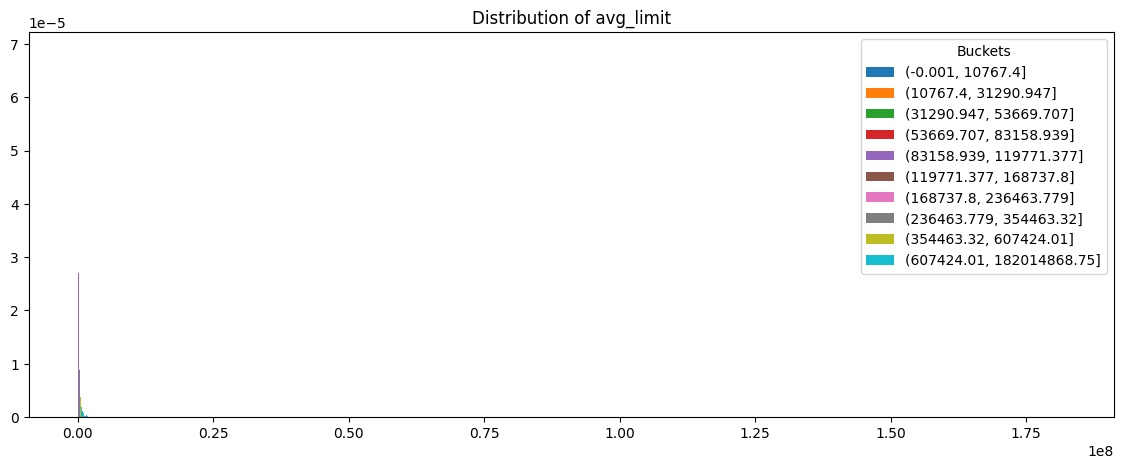

/Users/nikita/Desktop/вуз/ML/.venv/lib/python3.14/site-packages/sklearn/utils/validation.py:2684: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


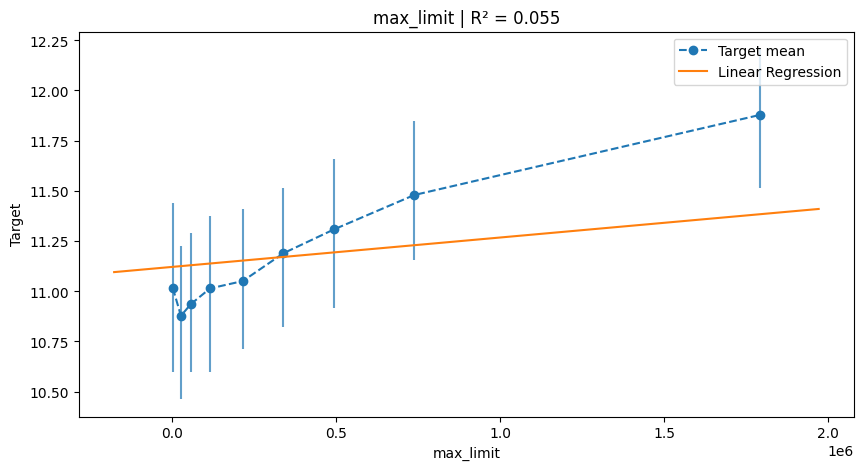

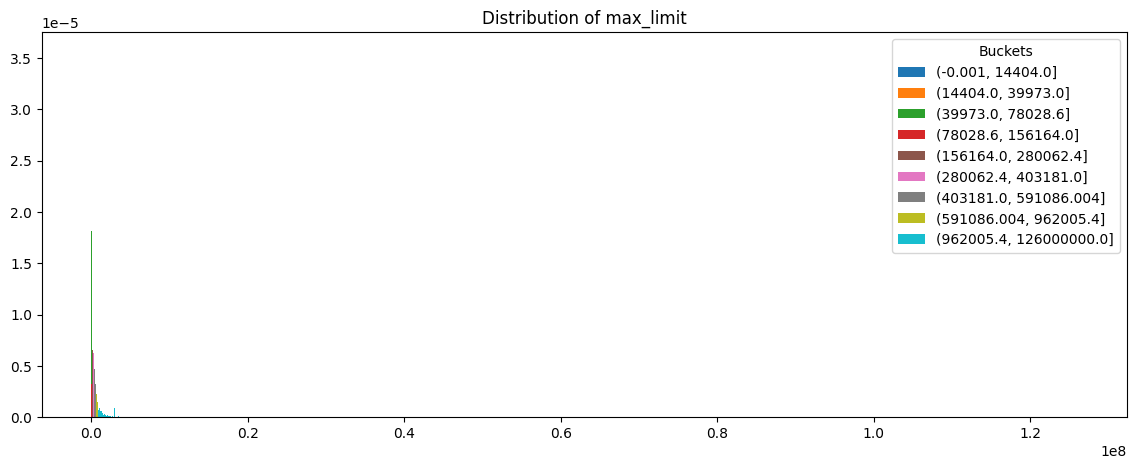

/Users/nikita/Desktop/вуз/ML/.venv/lib/python3.14/site-packages/sklearn/utils/validation.py:2684: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


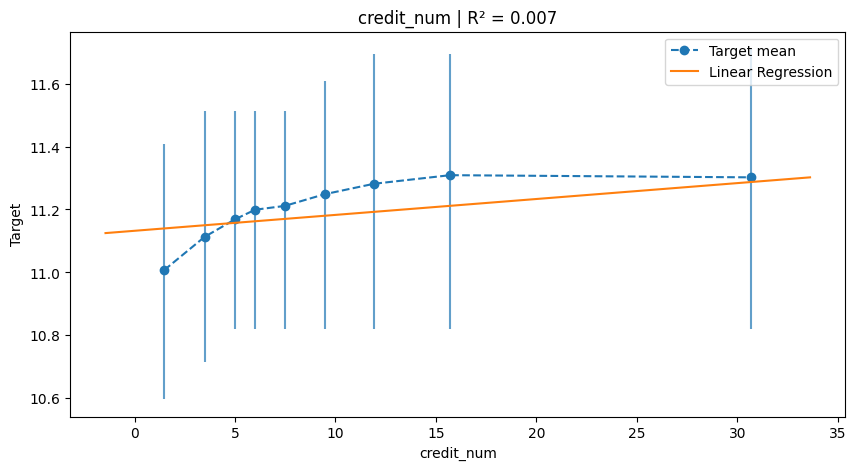

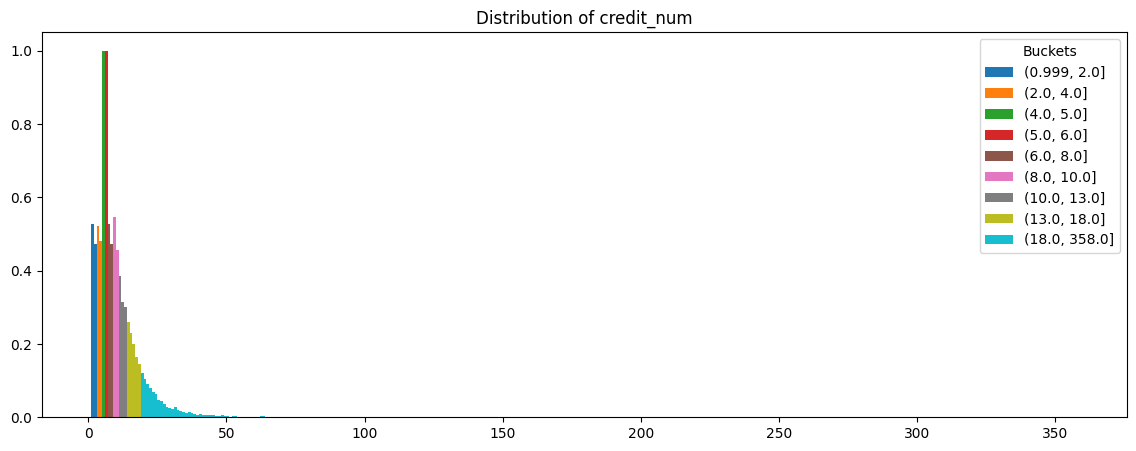

/Users/nikita/Desktop/вуз/ML/.venv/lib/python3.14/site-packages/sklearn/utils/validation.py:2684: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


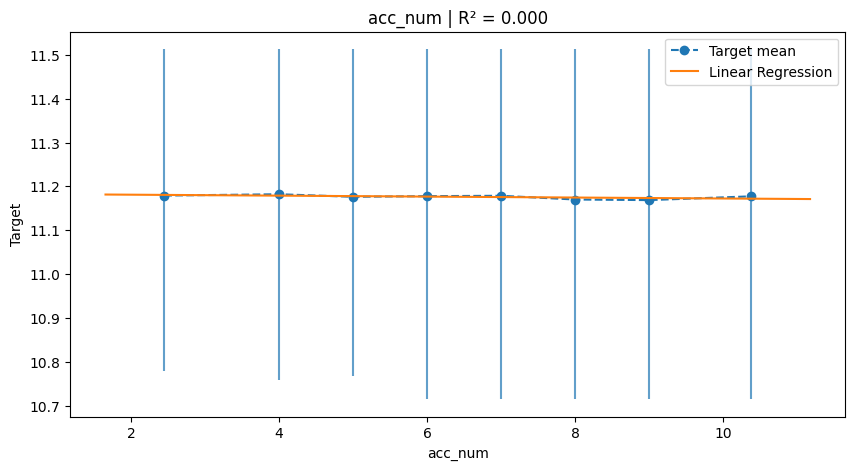

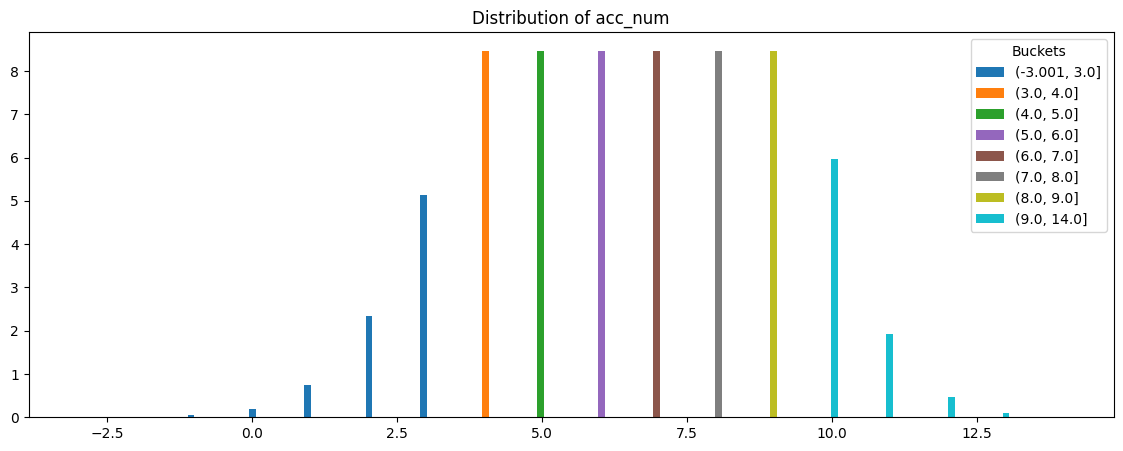

/Users/nikita/Desktop/вуз/ML/.venv/lib/python3.14/site-packages/sklearn/utils/validation.py:2684: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


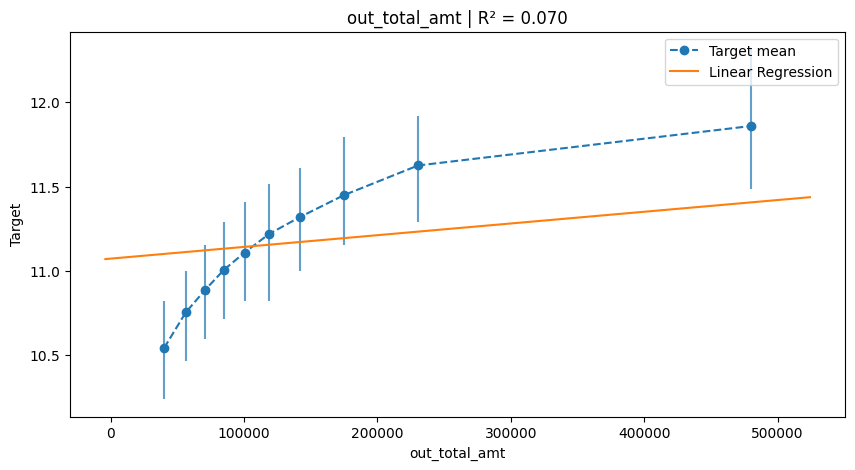

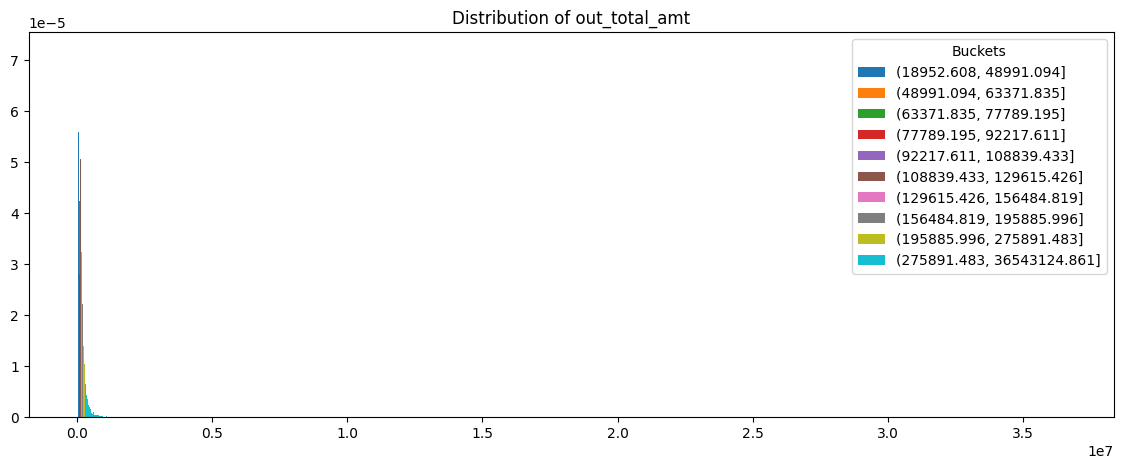

In [288]:
for feat in numeric:
    feature_line(X_train[feat], y_train, 10, feat)


<a id='task2'></a>
##### Задание 2 (1 балл)

Подобрать преобразование и линеаризовать признаки (для визуализации использовать feature_line()). Необходимо обосновать выбор преобразования.

Подсказка: линеаризовать признак age можно разбиением на линейные фрагменты

In [289]:
X_train['in_total_amt_log'] = np.log(X_train['in_total_amt'].clip(lower=3000, upper=400000))
X_test['in_total_amt_log'] = np.log(X_test['in_total_amt'].clip(lower=3000, upper=400000))

In [290]:
from scipy.interpolate import interp1d

# Признак job_salary демонстрирует монотонную, но слабую зависимость от целевой переменной. Монотонные преобразования не помогли

#для age точка перелома в +-36 лет
k = 36

X_train['age'] = X_train['age']  # оставляем исходный возраст
X_train['age_gt_36'] = np.maximum(0, X_train['age'] - 36)
X_test['age'] = X_test['age']  # оставляем исходный возраст
X_test['age_gt_36'] = np.maximum(0, X_test['age'] - 36)


lr1 = LinearRegression()
lr1.fit(X_train[['age']], y_train)
print("R2 age:", r2_score(y_train, lr1.predict(X_train[['age']])))

lr2 = LinearRegression()
lr2.fit(X_train[['age', 'age_gt_36']], y_train)
print("R2 piecewise:", r2_score(
    y_train,
    lr2.predict(X_train[['age', 'age_gt_36']])
))

b1 = lr2.coef_[0]
b2 = lr2.coef_[1]

print("Slope before 36:", b1)
print("Slope after 36:", b1 + b2)




R2 age: 0.011263466870563565
R2 piecewise: 0.060688638370553716
Slope before 36: 0.03804327327951653
Slope after 36: -0.017054057793446403


/Users/nikita/Desktop/вуз/ML/.venv/lib/python3.14/site-packages/sklearn/utils/validation.py:2684: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


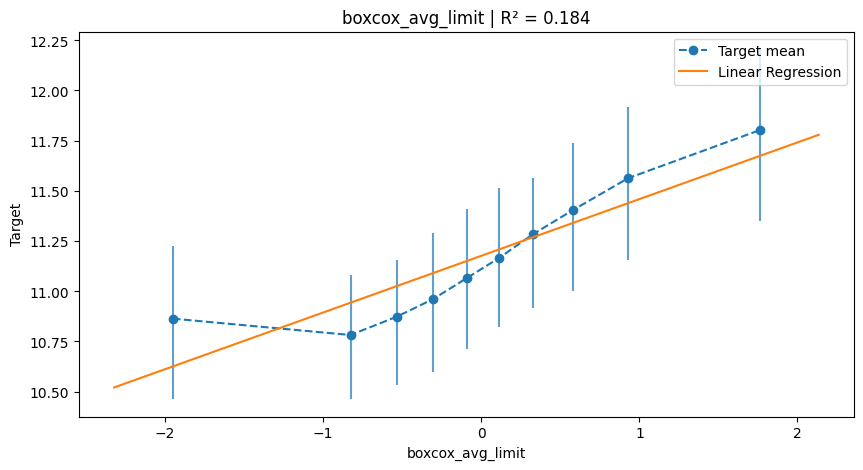

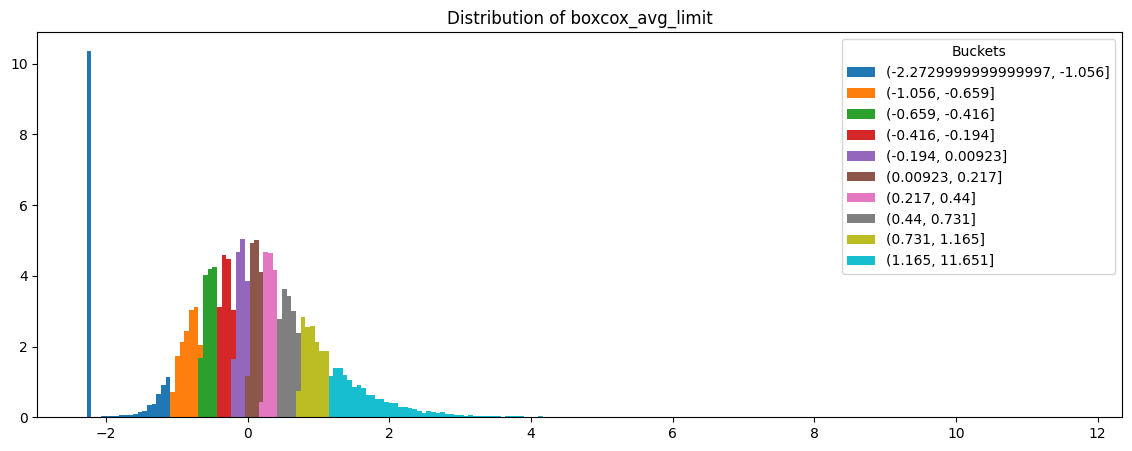

{'removed_obs': 0, 'r2': 0.1838804251698627}

In [291]:
#avg_limit хчоет

from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method='yeo-johnson')  
X_train['boxcox_avg_limit'] = pt.fit_transform(X_train[['avg_limit']]).ravel()
X_test['boxcox_avg_limit'] = pt.fit_transform(X_test[['avg_limit']]).ravel()

feature_line(X_train['boxcox_avg_limit'], y_train, 10, 'boxcox_avg_limit')

/Users/nikita/Desktop/вуз/ML/.venv/lib/python3.14/site-packages/sklearn/utils/validation.py:2684: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


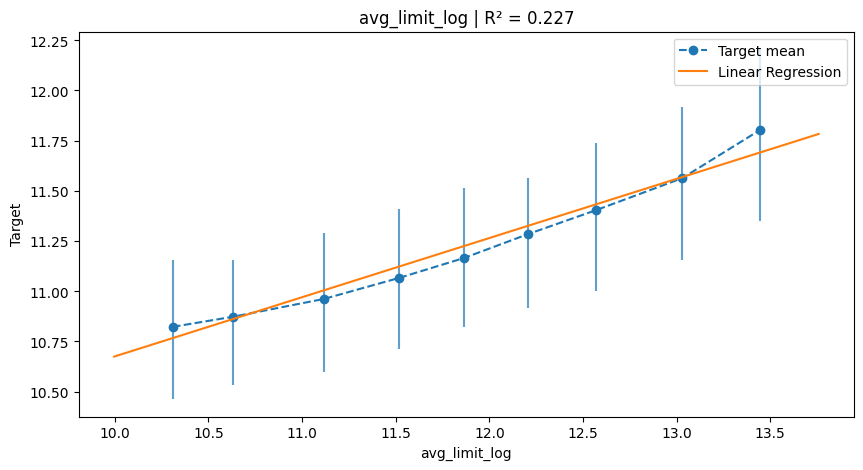

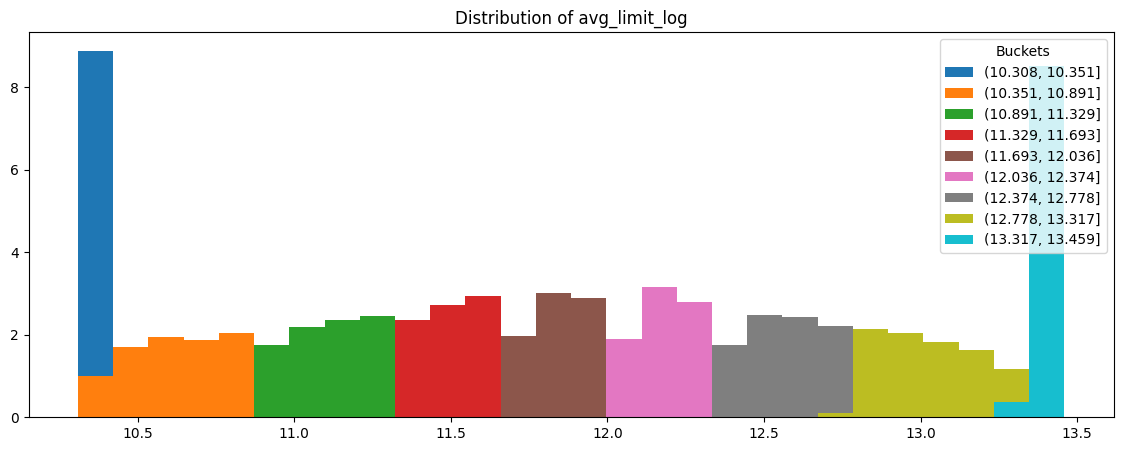

{'removed_obs': 0, 'r2': 0.22720743478169814}

In [292]:
X_train['avg_limit_log'] = np.log(X_train['avg_limit'].clip(lower=30000, upper = 700000))
X_test['avg_limit_log'] = np.log(X_test['avg_limit'].clip(lower=30000, upper = 700000))
feature_line(X_train['avg_limit_log'], y_train, 10, 'avg_limit_log')

/Users/nikita/Desktop/вуз/ML/.venv/lib/python3.14/site-packages/sklearn/utils/validation.py:2684: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


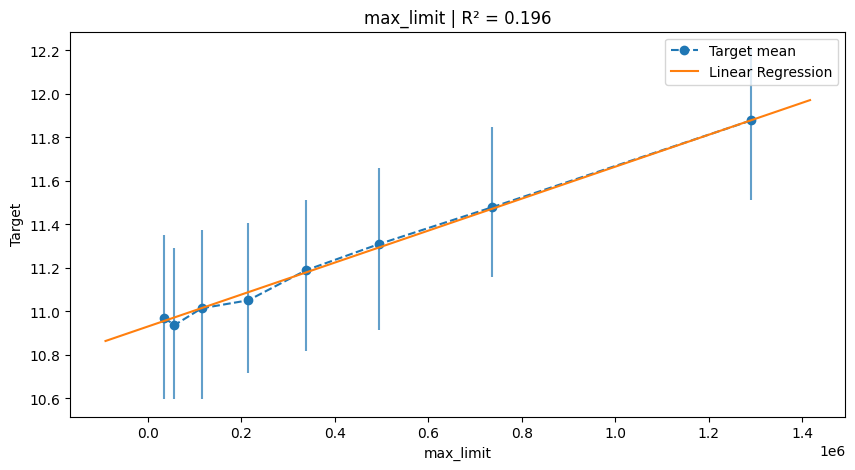

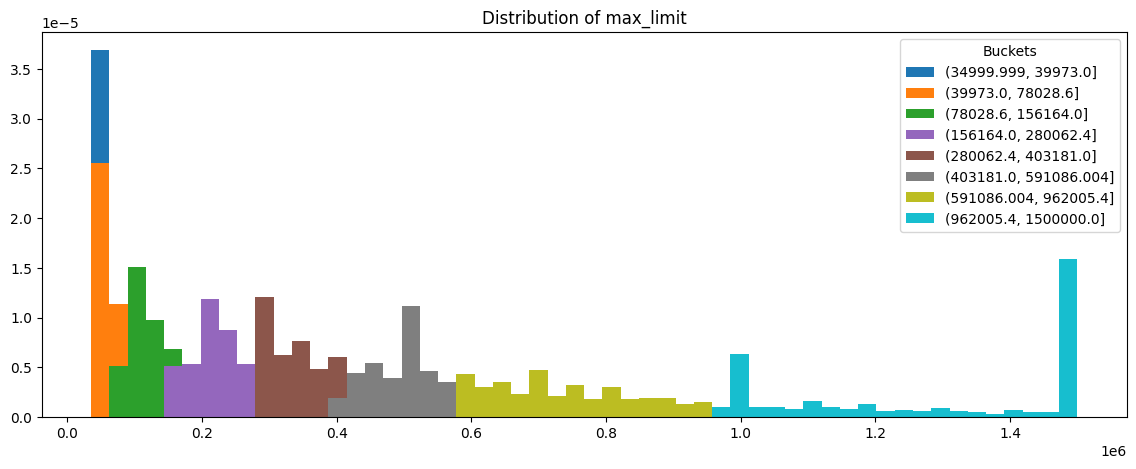

{'removed_obs': 0, 'r2': 0.19592610382332643}

In [293]:
# max limit
X_train['max_limit'] = (X_train['max_limit']).clip(lower=35000, upper = 1500000)
X_test['max_limit'] = (X_test['max_limit']).clip(lower=35000, upper = 1500000)
feature_line(X_train['max_limit'], y_train, 10, 'max_limit')


/Users/nikita/Desktop/вуз/ML/.venv/lib/python3.14/site-packages/sklearn/utils/validation.py:2684: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


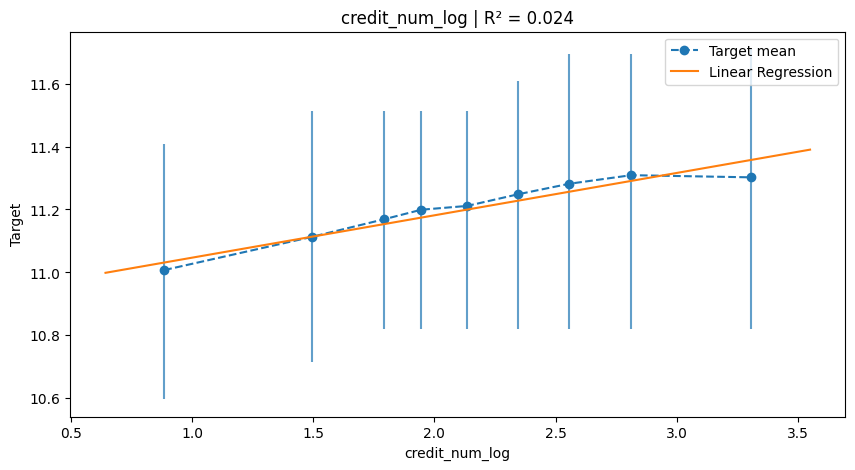

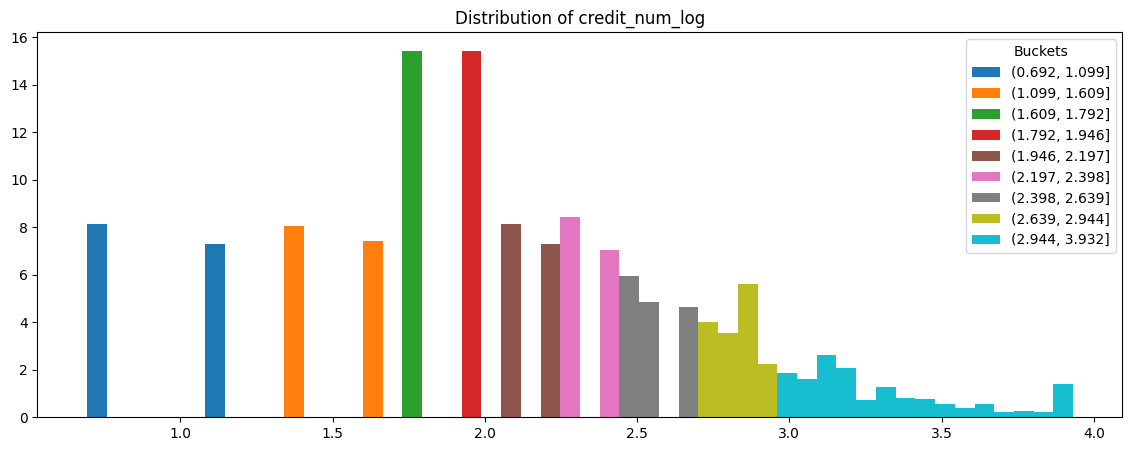

{'removed_obs': 0, 'r2': 0.024462554978022744}

In [294]:
X_train['credit_num_log'] = np.log1p((X_train['credit_num']).clip(upper = 50))
X_test['credit_num_log'] = np.log1p((X_test['credit_num']).clip(upper = 50))
feature_line(X_train['credit_num_log'], y_train, 10, 'credit_num_log')

/Users/nikita/Desktop/вуз/ML/.venv/lib/python3.14/site-packages/sklearn/utils/validation.py:2684: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


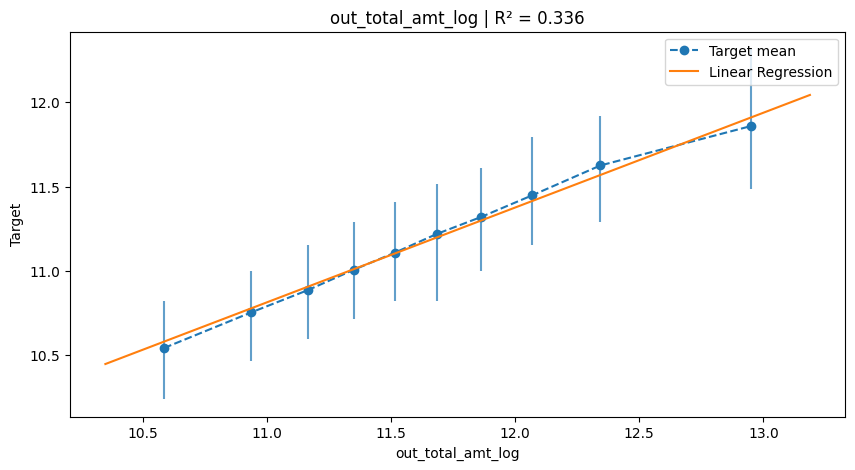

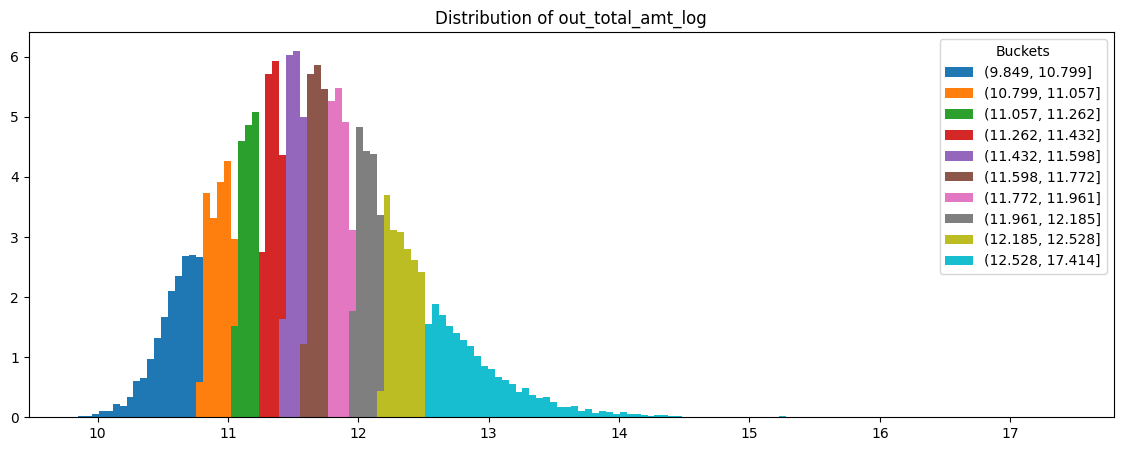

{'removed_obs': 0, 'r2': 0.3359990768325486}

In [295]:
#acc_num не имеет линейной связи с target

#out-total 

X_train['out_total_amt_log'] = np.log1p((X_train['out_total_amt']))
X_test['out_total_amt_log'] = np.log1p((X_test['out_total_amt']))
feature_line(X_train['out_total_amt_log'], y_train, 10, 'out_total_amt_log')

<a id='task3'></a>
##### Задание 3 (1 балл)

Решить проблему гетероскедастичности для признака in_total_amt. Проверить остальные признаки.

Подсказка: обратите внимание на ограничения значений признака in_total_amt

это 

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.176
Method:                 Least Squares   F-statistic:                     7519.
Date:                Sun, 25 Jan 2026   Prob (F-statistic):               0.00
Time:                        23:41:50   Log-Likelihood:                -34929.
No. Observations:               38640   AIC:                         6.986e+04
Df Residuals:                   38638   BIC:                         6.988e+04
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                8.9202      0.026  

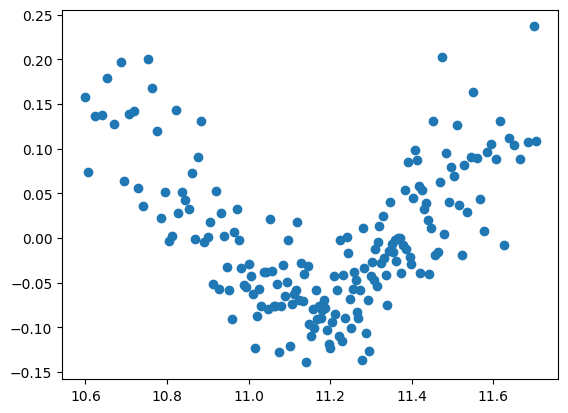

In [309]:
X_train['in_total_amt_log_sq'] = X_train['in_total_amt_log'] ** 2
plot_homoscedacity(X_train.in_total_amt_log_sq, y_train,'in_total_amt_log_sq')
#Трансформации признака (логарифмирование, клиппинг, полиномиальные члены) не устраняют эффект полностью, а ограничение уже сверху сделали.
model_robust = sm.OLS(y_train, sm.add_constant(X_train['in_total_amt_log'])).fit(cov_type='HC3')
print(model_robust.summary())

ols = sm.OLS(y_train, X_train).fit()
resid = ols.resid
sigma2_hat = resid**2
weights = 1 / sigma2_hat
wls = sm.WLS(y_train, X_train, weights=weights).fit()
print(wls.summary())

In [297]:
X_train

,in_total_amt,job_salary,age,avg_limit,max_limit,credit_num,acc_num,out_total_amt,in_total_amt_log,age_gt_36,boxcox_avg_limit,avg_limit_log,credit_num_log,out_total_amt_log
0,8110.825000,32000,22.0,12847.00000,35000.0,7,9.0,38657.606406,9.000955,0.0,-0.997515,10.308953,2.079442,10.562525
1,25600.000000,32000,26.0,26381.50000,35000.0,3,7.0,51272.839585,10.150348,0.0,-0.729735,10.308953,1.386294,10.844936
2,216091.400000,38000,25.0,9176.48857,35000.0,14,3.0,147950.296174,12.283457,0.0,-1.107730,10.308953,2.708050,11.904638
3,106000.661389,40000,36.0,32152.50000,35000.0,4,6.0,99925.392161,11.571201,0.0,-0.647647,10.378245,1.609438,11.512189
4,102672.375000,17000,23.0,38493.50000,585000.0,9,7.0,78125.045718,11.539298,0.0,-0.569497,10.558245,2.302585,11.266079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38635,55206.282895,73000,35.0,282537.00000,200000.0,2,4.0,148579.909349,10.918832,0.0,0.564191,12.551565,1.098612,11.908885
38636,183912.578571,144000,24.0,268517.00000,35000.0,1,10.0,269298.370679,12.122216,0.0,0.527999,12.500670,0.693147,12.503579
38637,4446.666667,47000,42.0,98318.30435,300000.0,29,8.0,66206.361955,8.399910,6.0,-0.103037,11.495965,3.401197,11.100547
38638,85384.080000,73000,32.0,83491.25000,76202.0,4,4.0,123867.891383,11.354915,0.0,-0.192081,11.332497,1.609438,11.726979


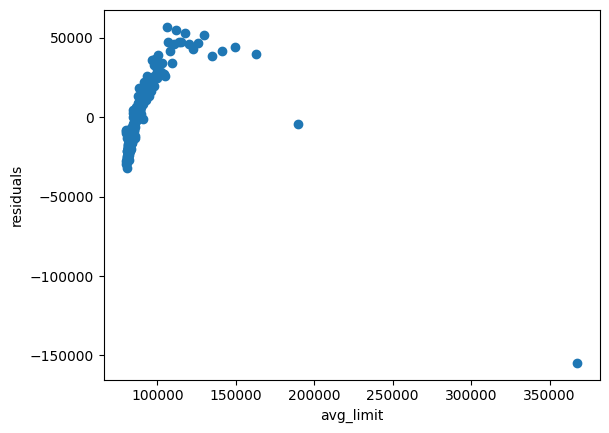

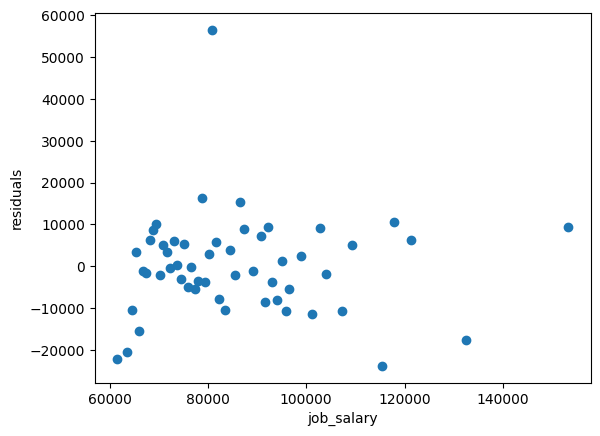

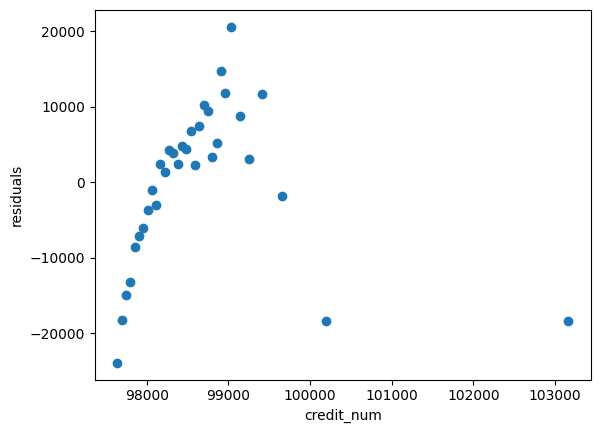

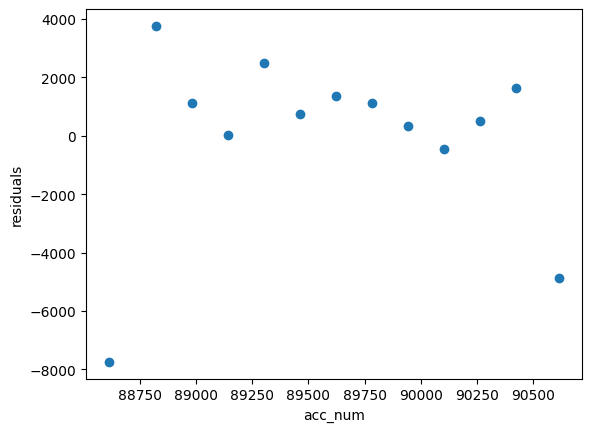

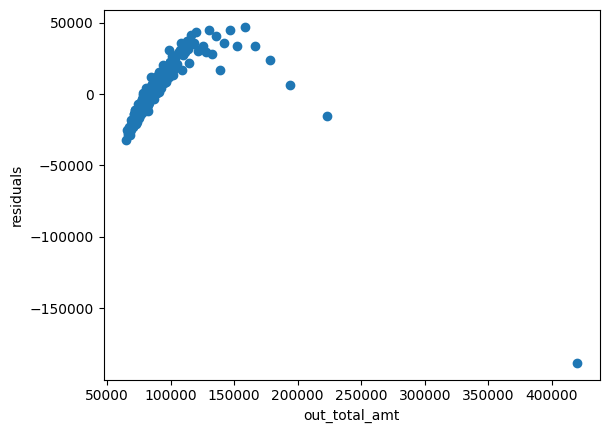

In [304]:
plot_homoscedacity(X_train.avg_limit, np.exp(y_train),'avg_limit')
plt.xlabel('avg_limit')
plt.ylabel('residuals')
plt.show()

plot_homoscedacity(X_train.job_salary, np.exp(y_train),'job_salary')
plt.xlabel('job_salary')
plt.ylabel('residuals')
plt.show()

plot_homoscedacity(X_train.credit_num, np.exp(y_train),'credit_num')
plt.xlabel('credit_num')
plt.ylabel('residuals')
plt.show()

plot_homoscedacity(X_train.acc_num, np.exp(y_train),'acc_num')
plt.xlabel('acc_num')
plt.ylabel('residuals')
plt.show()

plot_homoscedacity(X_train.out_total_amt, np.exp(y_train),'out_total_amt')
plt.xlabel('out_total_amt')
plt.ylabel('residuals')
plt.show()



<a id='task4'></a>
##### Задание 4 (1 балл)

Вычислить VIF для всех признаков. Исключить признаки, линейно зависящие от остальных.


In [299]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
from statsmodels.tools.tools import add_constant  
def remove_multicollinear_features(df, numeric_columns, vif_threshold=10):

    
    X = df[numeric_columns].copy()
    
    
    X_filled = X.fillna(X.median())
    
    
    cols_to_keep = numeric_columns.copy()
    removed_features = []
    
    while len(cols_to_keep) > 1:
        
        X_temp = add_constant(X_filled[cols_to_keep])
        
       
        vif_values = []
        for i in range(1, X_temp.shape[1]): 
            vif = variance_inflation_factor(X_temp.values, i)
            vif_values.append((X_temp.columns[i], vif))
        
        
        vif_df = pd.DataFrame(vif_values, columns=['feature', 'VIF'])
        max_vif_row = vif_df.loc[vif_df['VIF'].idxmax()]
        
        
        if max_vif_row['VIF'] > vif_threshold:
            feature_to_remove = max_vif_row['feature']
            cols_to_keep.remove(feature_to_remove)
            removed_features.append({
                'feature': feature_to_remove, 
                'VIF': max_vif_row['VIF']
            })
        else:
            break
    
    
    X_final = add_constant(X_filled[cols_to_keep])
    final_vif = []
    for i in range(1, X_final.shape[1]):
        vif = variance_inflation_factor(X_final.values, i)
        final_vif.append((X_final.columns[i], vif))
    
    vif_report = pd.DataFrame(final_vif, columns=['feature', 'VIF']).sort_values('VIF', ascending=False)
    
    print("Удаленные признаки из-за мультиколлинеарности:")
    for removed in removed_features:
        print(f"  - {removed['feature']}: VIF = {removed['VIF']:.2f}")
    
    print(f"\nОставшиеся признаки ({len(cols_to_keep)}):")
    print(f"  {cols_to_keep}")
    
    return df[cols_to_keep], vif_report



X_train_filtered, vif_report = remove_multicollinear_features(
    X_train, 
    numeric, 
    vif_threshold=10
)

print(f"Исходно признаков: {len(numeric)}")
print(f"Осталось признаков: {X_train_filtered.shape[1]}")
print(f"Удалено: {len(numeric) - X_train_filtered.shape[1]}")

Удаленные признаки из-за мультиколлинеарности:
  - out_total_amt: VIF = 63450.25

Оставшиеся признаки (7):
  ['in_total_amt', 'job_salary', 'age', 'avg_limit', 'max_limit', 'credit_num', 'acc_num']
Исходно признаков: 8
Осталось признаков: 7
Удалено: 1


In [300]:
X_test_filtered = X_test.drop("out_total_amt", axis=1)

<a id='task5'></a>
##### Задание 5 (2 балла)

Построить модель линейной регрессии на рассмотренных и остальных признаках. Не забудьте проверить нормальность остатков вашей модели. 

Вычислить метрику $R^2$ и сравнить с baseline.

In [301]:
X_train_filtered = X_train.drop(columns=["out_total_amt", "credit_num", "avg_limit", "boxcox_avg_limit", "in_total_amt", "acc_num", "credit_num_log"])
X_test_filtered = X_test.drop(columns=["out_total_amt", "credit_num", "avg_limit", "boxcox_avg_limit", "in_total_amt", "acc_num", "credit_num_log"])

In [302]:
X_train_filtered

,job_salary,age,max_limit,in_total_amt_log,age_gt_36,avg_limit_log,out_total_amt_log
0,32000,22.0,35000.0,9.000955,0.0,10.308953,10.562525
1,32000,26.0,35000.0,10.150348,0.0,10.308953,10.844936
2,38000,25.0,35000.0,12.283457,0.0,10.308953,11.904638
3,40000,36.0,35000.0,11.571201,0.0,10.378245,11.512189
4,17000,23.0,585000.0,11.539298,0.0,10.558245,11.266079
...,...,...,...,...,...,...,...
38635,73000,35.0,200000.0,10.918832,0.0,12.551565,11.908885
38636,144000,24.0,35000.0,12.122216,0.0,12.500670,12.503579
38637,47000,42.0,300000.0,8.399910,6.0,11.495965,11.100547
38638,73000,32.0,76202.0,11.354915,0.0,11.332497,11.726979


R² на train: 0.4009
R² на test: 0.4064

BASELINE (предсказываем среднее):
R² baseline: 0.0000
Улучшение относительно baseline: 0.4009

Коэффициенты модели:
             feature          coef      abs_coef
6  out_total_amt_log  2.785858e-01  2.785858e-01
3   in_total_amt_log  5.745500e-02  5.745500e-02
5      avg_limit_log  2.796306e-02  2.796306e-02
4          age_gt_36 -2.386409e-02  2.386409e-02
1                age  1.173492e-02  1.173492e-02
0         job_salary  3.514671e-06  3.514671e-06
2          max_limit  3.871933e-07  3.871933e-07


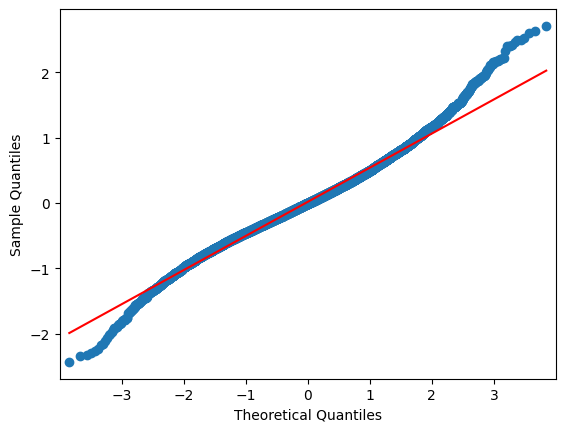

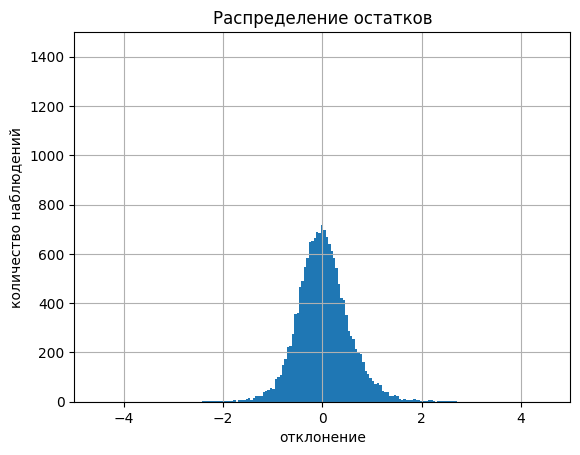

In [303]:
from sklearn.preprocessing import StandardScaler

model = LinearRegression()
model.fit(X_train_filtered, y_train)

y_train_pred = model.predict(X_train_filtered)
y_test_pred = model.predict(X_test_filtered)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred) if y_test is not None else None

print(f"R² на train: {r2_train:.4f}")
print(f"R² на test: {r2_test:.4f}")

baseline_pred = np.full_like(y_train, y_train.mean())
r2_baseline = r2_score(y_train, baseline_pred)

print(f"\nBASELINE (предсказываем среднее):")
print(f"R² baseline: {r2_baseline:.4f}")
print(f"Улучшение относительно baseline: {r2_train - r2_baseline:.4f}")

# Коэффициенты модели
print(f"\nКоэффициенты модели:")
coef_df = pd.DataFrame({
    'feature': X_train_filtered.columns,
    'coef': model.coef_,
    'abs_coef': np.abs(model.coef_)
}).sort_values('abs_coef', ascending=False)

print(coef_df.head(10))


resids = get_residuals(y_test,y_test_pred)
  
data_points = np.random.normal(0, 1, 100000)    
  
sm.qqplot(np.array(resids), line='s')
py.show()

plt.hist(resids, bins='auto')[2]
plt.xlabel('отклонение')
plt.ylabel('количество наблюдений')
plt.title('Распределение остатков')
plt.axis([-5, 5, 0, 1500])
plt.grid(True)
plt.show()

<a id='task6'></a>
##### Задание 6 (2 балла)

Рассмотрим выборку для **парной** регрессии: $y = (y_1, \ldots, y_n)\quad x = (x_1, \ldots, x_n)$

С помощью МНК можно найти коэффициенты
$$
\hat y_i = \hat \beta_0 + \hat \beta_1 x_i,\quad \hat \beta_0 = \overline y - \hat \beta_1 \overline x,\quad
\hat \beta_1 = \frac{\sum (x_i - \overline x)(y_i - \overline y)}{\sum (x_i - \overline x)^2}
$$

Доказать, что $$R^2 = \rho^2$$ где 

$$
R^2 = 1 - \frac{\sum (y_i - \hat y) ^ 2}{\sum (y_i - \overline y) ^ 2}
$$

$$
\rho =
\frac{ \frac{1}{n} \sum (x_i - \overline x)(y_i - \overline y)}
{ \sqrt {\frac{1}{n} \sum (x_i - \overline x)^2 \frac{1}{n} \sum (y_i - \overline y)^2 }}
$$

– выборочный коэффициент корреляции.

Для простоты можно предполагать, что $x$ и $y$ **стандартизированы** (имеют нулевое выборочное среднее и единичную выборочную дисперсию).

# Доказательство: $ R^2 = \rho^2 $ для стандартизированных переменных

## Шаг 1: Стандартизация

Пусть переменные $ x $ и $ y $ стандартизированы:

$$
\bar{x} = 0,\quad \bar{y} = 0,\quad \frac{1}{n} \sum x_i^2 = 1,\quad \frac{1}{n} \sum y_i^2 = 1
$$

Это означает:
- средние значения равны нулю,
- выборочные дисперсии равны единице.

---

## Шаг 2: Формулы для коэффициентов регрессии

Для простой линейной регрессии $ \hat{y}_i = \hat{\beta}_0 + \hat{\beta}_1 x_i $:

- Наклон:
  $$
  \hat{\beta}_1 = \frac{\sum x_i y_i}{\sum x_i^2} = \frac{\sum x_i y_i}{n}
  $$
  (поскольку $ \sum x_i^2 = n $ из условия стандартизации)

- Свободный член:
  $$
  \hat{\beta}_0 = \bar{y} - \hat{\beta}_1 \bar{x} = 0 - \hat{\beta}_1 \cdot 0 = 0
  $$

Следовательно, модель упрощается до:
$$
\hat{y}_i = \hat{\beta}_1 x_i = \left( \frac{\sum x_j y_j}{n} \right) x_i
$$

---

## Шаг 3: Коэффициент детерминации $ R^2 $

Общая формула:
$$
R^2 = 1 - \frac{SS_{\text{res}}}{SS_{\text{tot}}}
$$

где:
- $ SS_{\text{tot}} = \sum (y_i - \bar{y})^2 = \sum y_i^2 = n $ (так как $ \bar{y} = 0 $ и $ \frac{1}{n} \sum y_i^2 = 1 $)
- $ SS_{\text{res}} = \sum (y_i - \hat{y}_i)^2 $

---

## Шаг 4: Вычисление $ SS_{\text{res}} $

Подставим $ \hat{y}_i = \left( \frac{\sum x_j y_j}{n} \right) x_i $:

$$
SS_{\text{res}} = \sum \left( y_i - \frac{\sum x_j y_j}{n} x_i \right)^2
$$

Раскроем квадрат:

$$
SS_{\text{res}} = \sum y_i^2 - 2 \cdot \frac{\sum x_j y_j}{n} \sum x_i y_i + \left( \frac{\sum x_j y_j}{n} \right)^2 \sum x_i^2
$$

Используем свойства стандартизированных данных:
- $ \sum y_i^2 = n $
- $ \sum x_i^2 = n $
- $ \sum x_i y_i = n \rho $

Тогда:

$$
SS_{\text{res}} = n - 2 \cdot \frac{n \rho}{n} \cdot n \rho + \left( \frac{n \rho}{n} \right)^2 \cdot n
= n - 2n\rho^2 + n\rho^2 = n(1 - \rho^2)
$$

---

## Шаг 5: Подстановка в формулу $ R^2 $

$$
R^2 = 1 - \frac{SS_{\text{res}}}{SS_{\text{tot}}} = 1 - \frac{n(1 - \rho^2)}{n} = 1 - (1 - \rho^2) = \rho^2
$$


$$
\boxed{R^2 = \rho^2}
$$

